# Preamble

In [1]:
CODE_PATH = r'C:/Git/HonoursProject/ipw-clusterer/ipw_clusterer/'
DATA_PATH = r'C:/Git/HonoursProject/ipw-clusterer/data/'

#Show Exploratory Data Analyis?
EDA = False

In [2]:
# add source python files to project
import sys
sys.path.insert(0, CODE_PATH) 
import ipw

In [3]:
#import io
import logging
import numpy as np
import pandas as pd
#import re
#import math

In [4]:
logging.basicConfig(filename = 'log.txt', level = logging.DEBUG, format='%(asctime)s %(levelname)s %(message)s')

# Load the data

In [5]:
df = ipw.parse.read(DATA_PATH)

## Nr of records

In [6]:
if EDA:
    print(f'Total records: {len(df)}')
    print('Records per status:')
    print(df['status'].value_counts(dropna = False))

In [7]:
# Select closed records
df = df[df['status'] == 'closed']
df.drop('status', axis = 1, inplace = True)

## Clean the text fields

In [8]:
df = ipw.parse.clean(df)

# Exploratory Data Analytics

In [9]:
import matplotlib.pyplot as plt

## Summary statistics

In [10]:
# Create a new DataFrame with the length of each string field in words per record  
if EDA:
    df_stats = df.apply(lambda x: x.fillna('').str.split().apply(len)) 
    summary_stats = df_stats.describe()
    for col in df_stats.columns:
        summary_stats.loc['empty', col] = df_stats[col].value_counts(sort = False).get(0, 0)
        summary_stats.loc['not_empty', col] = summary_stats.loc['count', col] - summary_stats.loc['empty', col]
    display(summary_stats)

In [11]:
# Create a box and whisker plot
if EDA:
    plt.boxplot(df_stats)
    plt.xticks(rotation=45)
    plt.xticks(range(1, len(df_stats.columns) + 1), df_stats.columns)
    plt.show()

## Unique words and occurances

In [12]:
if EDA:
    words_dict = {}

    for column in df:
        for index, row in df.iterrows():
                words_dict = ipw.text.add_word_count_to_dict(row[column], words_dict)

    total_words = sum(words_dict.values())
    print(f'Total words: {total_words}')
    print(f'Unique words: {len(words_dict)}')
    print(f'Average occurance: {total_words / len(words_dict):.2f}')

In [13]:
if EDA:
    ipw.plots.wordcloud(words_dict).show()
    ipw.plots.histogram_wordfreq(words_dict).show()

# Transform the data

## Nouns in description column

In [14]:
df_model_1 = df['description'].apply(ipw.text.filter).to_frame('text')

In [15]:
obs_dict = {}

for index, row in df_model_1.iterrows():
    obs_dict = ipw.text.add_word_count_to_dict(row['text'], obs_dict)
     
total_words = sum(obs_dict.values())
print(f'Total words for model: {total_words}')
print(f'Unique words: {len(obs_dict)}')
print(f'Average occurance: {total_words / len(obs_dict):.2f}')


Total words for model: 21490
Unique words: 3251
Average occurance: 6.61


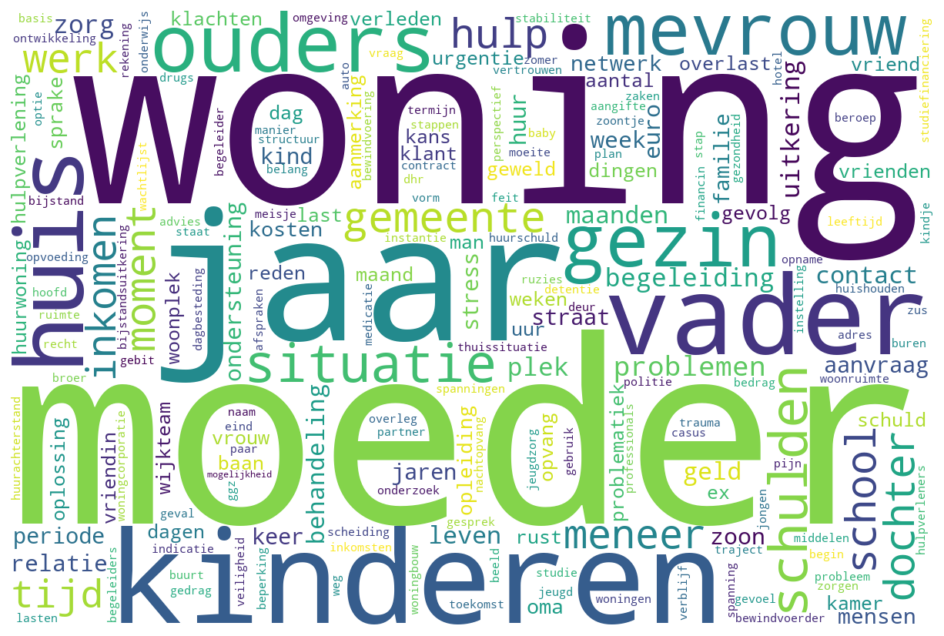

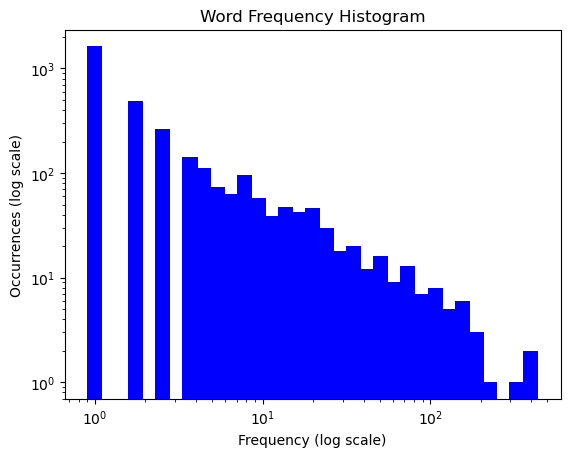

In [16]:
ipw.plots.wordcloud(obs_dict, 12, 8).show()
ipw.plots.histogram_wordfreq(obs_dict).show()

## spaCy vector

In [17]:
import spacy
import nl_core_news_lg

In [18]:
# load natural language model for dutch
nlp = nl_core_news_lg.load()

In [19]:
# Create a list of series objects representing the columns of the new DataFrame  
vector_names = [f"V{i}" for i in range(nlp.vocab.vectors_length)]  
column_list = [] 

for name in vector_names:
     column_list.append(pd.Series(name=name, index=df.index, dtype=float))  
  
# Loop over the strings in the original DataFrame and add their spaCy vectors to the column Series objects  
for i, text in enumerate(df_model_1['text']):  
    doc = nlp(text)  
    for j, value in enumerate(doc.vector):  
        column_list[j][i] = value  
  
# Concatenate the column Series objects to create the new DataFrame  
df_vector_1 = pd.concat(column_list, axis=1)  

## Remove samples that have empty vectors

In [20]:
# Calculate the norm of each row using np.linalg.norm()  
norms = df_vector_1.apply(lambda row: np.linalg.norm(row), axis=1)  

print(f'Number of samples before selection: {len(df)}')
# Filter out the rows where the norm is zero  
df_vector_1 = df_vector_1[norms != 0]  

print(f'Number of samples for clustering: {len(df_vector_1)}')

# also remove from the original dataframe with text
df_model_1 = df_model_1[df_model_1.index.isin(df_vector_1.index)]

Number of samples before selection: 392
Number of samples for clustering: 386


## Correlation

In [21]:
import seaborn as sns

In [22]:
if EDA:
    plt.figure(figsize=(10,10))
    correlation = df_vector_1.corr()
    correlation = np.triu(correlation, k=1)  # Keep only the upper triangle of the correlation matrix  

    sns.heatmap(abs(correlation), center = 0, cmap="RdBu", vmax = 1.0, vmin = 0.0)
    print(f'Max correlation: {correlation.max() :.3f}')  
    print(f'Min correlation: {correlation.min() :.3f}')  
    print(f'Mean absolute correlation: {(abs(correlation)).mean():.3f}')

# Models

In [23]:
#from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, SpectralClustering
from sklearn import metrics

## Set Random State

In [24]:
# Set to be able to get repeatable results
RANDOM_STATE = 42

## Distance and affinity matrix

In [25]:
dist_matrix = ipw.models.distance_matrix(df_vector_1)

## Affinity Propagation

In [26]:
dampings = np.arange(0.5, 1.0, 0.05) 
af_results, af_labels, af_centers = ipw.models.affinity_propagation(dist_matrix, dampings, random_state = RANDOM_STATE)

Cluster size per cluster
Cluster 0: 44
Cluster 1: 342
----
Best result:
----
Affinity Propagation damping Factor: 0.5
Number of clusters: 2.0
Silhouette Coefficient: 0.238
Calinski-Harabasz Index / Variance Ratio Criterion: 43.771
Davies-Bouldin Index: 1.725


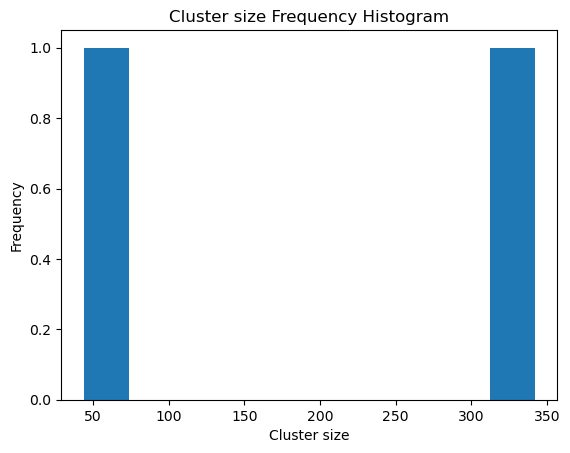

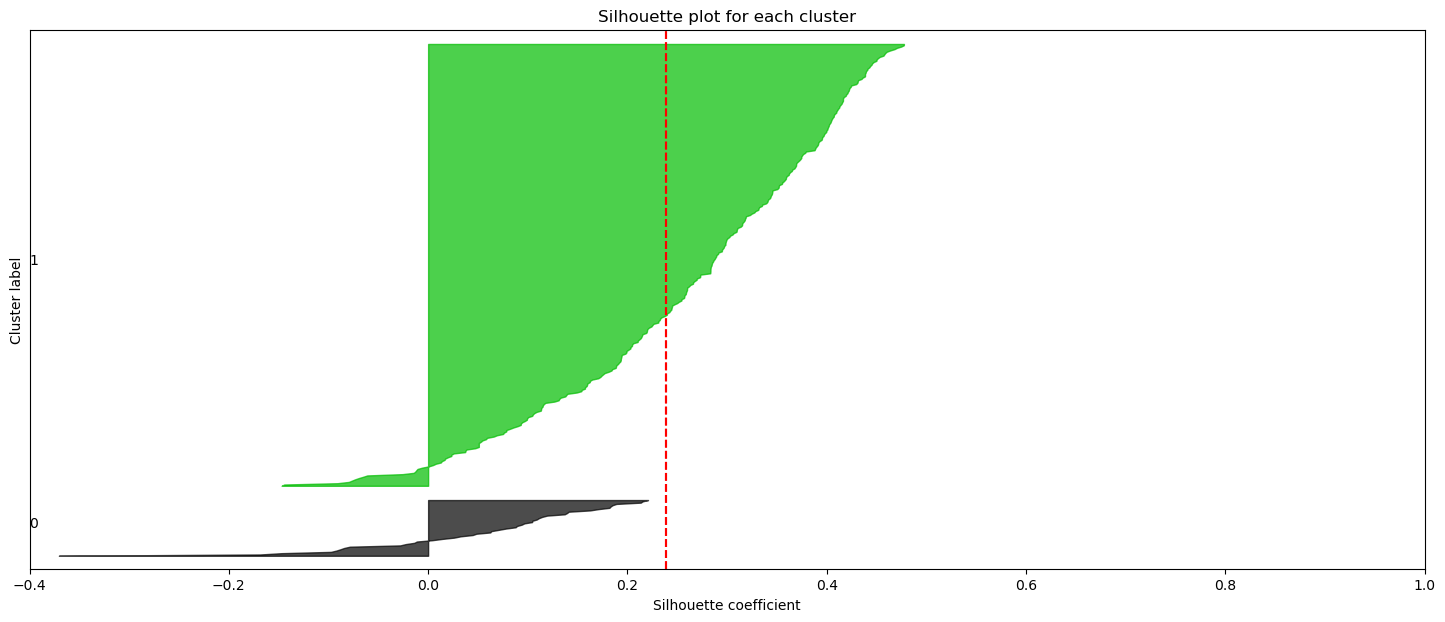

In [27]:
ipw.models.output(dist_matrix, af_results, af_labels)

# Agglomerative Clustering

In [28]:
# Dataframe for hyperparameter damping and results
n_clusters = range(2, 20)
ac_results, ac_labels = ipw.models.agglomerative_clustering(dist_matrix, n_clusters, RANDOM_STATE)

Cluster size per cluster
Cluster 0: 385
Cluster 1: 1
----
Best result:
----
Number of clusters: 2.0
Silhouette Coefficient: 0.665
Calinski-Harabasz Index / Variance Ratio Criterion: 27.034
Davies-Bouldin Index: 0.173


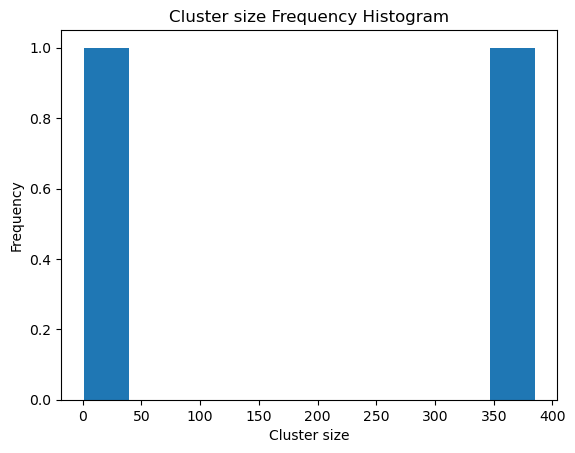

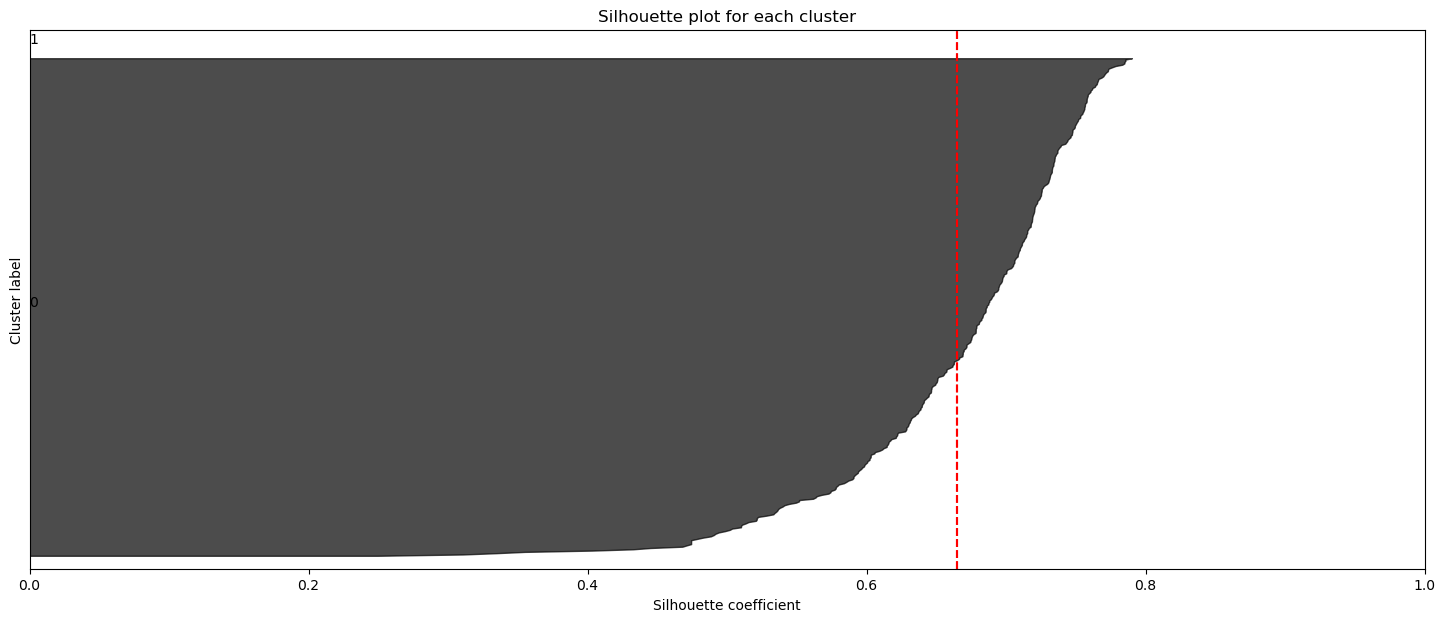

In [29]:
ipw.models.output(dist_matrix, ac_results, ac_labels)

# Spectral Clustering

In [30]:
# Dataframe for hyperparameter n_clusters and results
n_clusters = range(2, 10)
sc_results, sc_labels = ipw.models.spectral_clustering(dist_matrix, n_clusters, RANDOM_STATE)

Cluster size per cluster
Cluster 0: 187
Cluster 1: 199
----
Best result:
----
Number of clusters: 2.0
Silhouette Coefficient: 0.191
Calinski-Harabasz Index / Variance Ratio Criterion: 64.422
Davies-Bouldin Index: 2.124


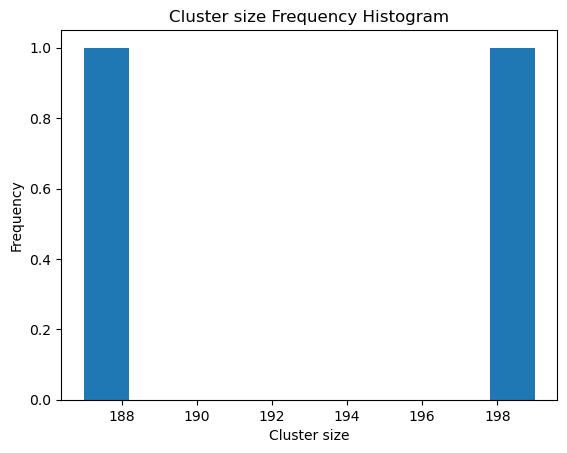

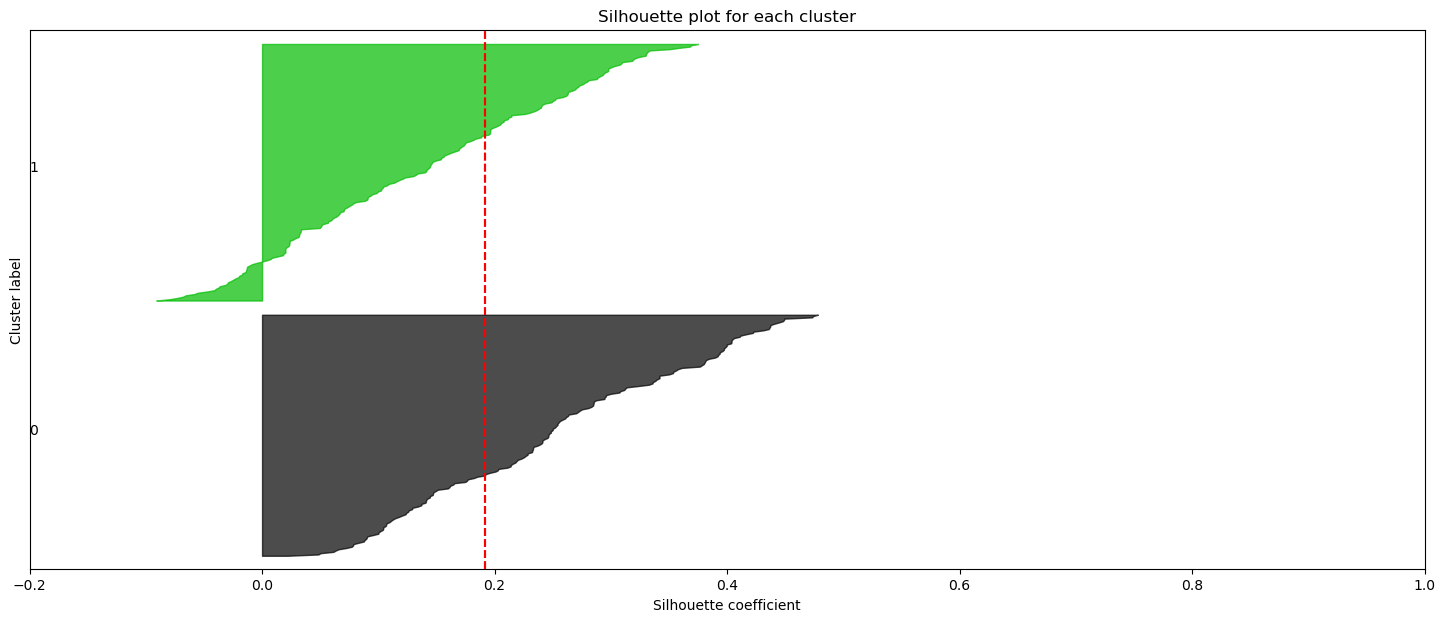

In [31]:
ipw.models.output(dist_matrix, sc_results, sc_labels)

# DBScan

In [32]:
eps_arr = np.arange(0.01, 0.2, 0.01) 
min_samples = range(2, 10)
db_results, db_labels = ipw.models.dbscan(dist_matrix, eps_arr, min_samples)

Cluster size per cluster
Cluster -1: 105
Cluster 0: 274
Cluster 1: 7
----
Best result:
----
DBScan epsilon: 0.08
DBScan Weight for core points: 5.0
Number of clusters: 2.0
Silhouette Coefficient: 0.226
Calinski-Harabasz Index / Variance Ratio Criterion: 111.451
Davies-Bouldin Index: 1.199


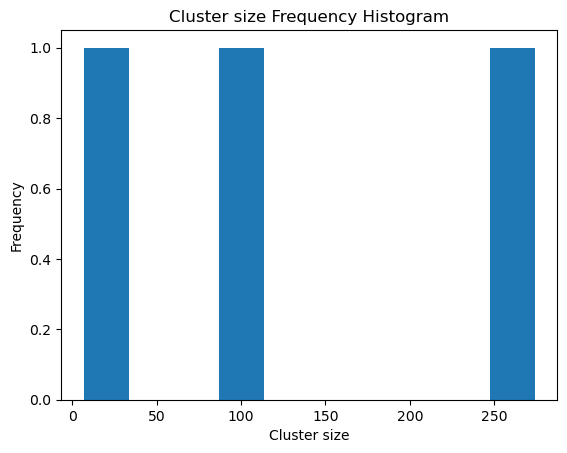

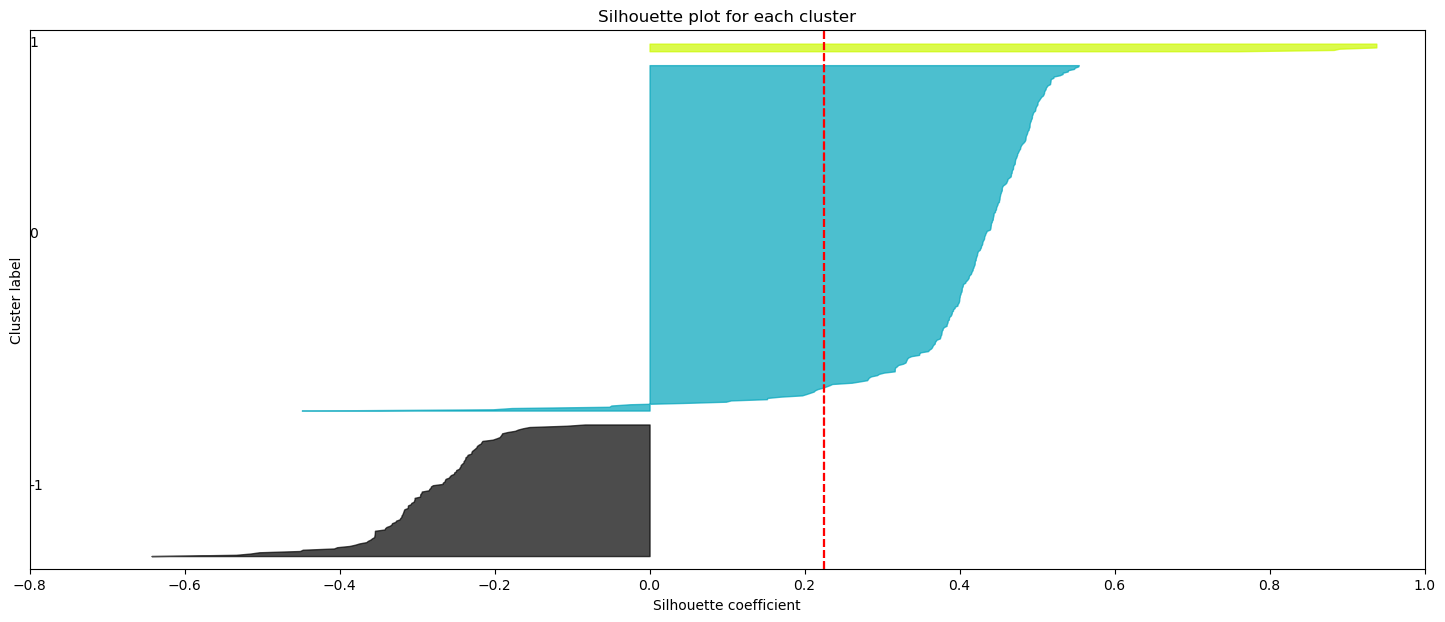

In [33]:
ipw.models.output(dist_matrix, db_results, db_labels)

# NOG FIXEN

In [ ]:
af_label_dicts = ipw.text.words_per_label(df_model_1, af_labels)

In [ ]:
def plot_wordclouds(label_dicts):
    return

    wordclouds = [plot_functions.wordcloud_from_dict(value, 5, 5) for value in label_dicts.values()]

    # Create a grid of subplots, ncols wide or less if there are less clusters
    ncols = min(5, n)
    nrows = int(np.ceil(len(wordclouds) / ncols))
    nplots = ncols * nrows

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))  
    keys = list(label_dicts.keys())

    # Plot each individual wordcloud in a separate subplot  
    for i in range(nplots): 
        row = i // ncols
        col = i % ncols
        if nrows == 1:
            if i < len(wordclouds):
                index = keys.index(i)
                axs[col].imshow(wordclouds[index].to_array(), interpolation='bilinear')  
                axs[col].set_title(f'Cluster {keys[index]}', pad = 15)
            axs[col].axis('off')  
        else:
            if i < len(wordclouds):
                index = keys.index(i)
                axs[row, col].imshow(wordclouds[index].to_array(), interpolation='bilinear')  
                axs[row, col].set_title(f'Cluster {keys[index]}')
            axs[row, col].axis('off')  


    # Show the grid of subplots  
    plt.show() 